<a href="https://colab.research.google.com/github/nishantgovil03/Research/blob/master/LSTMSummary_GPU_20epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%pwd


'/content'

In [5]:
%ls 

drive/  sample_data/


In [6]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [7]:
import pandas as pd

In [8]:
data = pd.read_csv("InputData.csv")

In [9]:
data

,Unnamed: 0,Articles without stop words,Article with stop words,Summary
0,0,budget set scene electiongordon brown seek put...,budget to set scene for electiongordon brown w...,<START> increase in the stamp duty threshold f...
1,1,army chiefs regiments decisionmilitary chiefs ...,army chiefs in regiments decisionmilitary chie...,<START> they are very much not for the good an...
2,2,howard denies split id cardsmichael howard den...,howard denies split over id cardsmichael howar...,<START> michael howard has denied his shadow c...
3,3,observers monitor uk electionministers invite ...,observers to monitor uk electionministers will...,<START> the report said individual registratio...
4,4,kilroy names election seat show host robert co...,kilroy names election seat show host robert is...,<START> ukip roger has said he is glad to see ...
...,...,...,...,...
4445,4445,india opens skies competitionindia allow domes...,india opens skies to competitionindia will all...,<START> india will allow domestic commercial a...
4446,4446,yukos bankruptcy us authorities abide us court...,yukos bankruptcy us authorities do not have to...,<START> yukos says a us court was entitled to ...
4447,4447,survey confirms property slowdowngovernment fi...,survey confirms property slowdowngovernment fi...,<START> house prices were higher on the year i...
4448,4448,high fuel prices hit ba profitsbritish airways...,high fuel prices hit ba profitsbritish airways...,<START> rod ba chief said the results were res...


In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Flatten,Dropout,BatchNormalization,Embedding,Input,TimeDistributed
from sklearn.model_selection import train_test_split

In [45]:
X_train,X_val,Y_train,Y_val=train_test_split(data['Article with stop words'],data['Summary'],test_size=0.3,random_state=29)
print(len(X_train),len(Y_train))
print(len(X_val),len(Y_val))

3115 3115
1335 1335


In [80]:
max_art_len=400
max_sum_len=100

In [81]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [82]:
article_tokenizer=Tokenizer(oov_token='<UNK>')
article_tokenizer.fit_on_texts(X_train)
tokenized_X_train=article_tokenizer.texts_to_sequences(X_train)
tokenized_X_val=article_tokenizer.texts_to_sequences(X_val)

art_vocab_size=len(article_tokenizer.word_index)+1

In [83]:
art_vocab_size

24225

In [84]:
padded_X_train=pad_sequences(tokenized_X_train,maxlen=max_art_len,padding='post',truncating='post')
padded_X_val=pad_sequences(tokenized_X_val,maxlen=max_art_len,padding='post',truncating='post')

In [85]:
print(padded_X_train.shape,padded_X_val.shape)

(3115, 400) (1335, 400)


In [86]:
summary_tokenizer=Tokenizer(oov_token='<UNK>')
summary_tokenizer.fit_on_texts(Y_train)
tokenized_Y_train=summary_tokenizer.texts_to_sequences(Y_train)
tokenized_Y_val=summary_tokenizer.texts_to_sequences(Y_val)

sum_vocab_size=len(summary_tokenizer.word_index)+1

In [87]:
sum_vocab_size

15775

In [88]:
padded_Y_train=pad_sequences(tokenized_Y_train,maxlen=max_sum_len,padding='post',truncating='post')
padded_Y_val=pad_sequences(tokenized_Y_val,maxlen=max_sum_len,padding='post',truncating='post')

In [89]:
print(padded_Y_train.shape,padded_Y_val.shape)

(3115, 100) (1335, 100)


In [90]:
embedding_size = 100
n_units = 300

In [91]:
#model = models.Sequential()
#model.add(layers.Dense(16, activation='relu',input_shape=(max_art_len,)))
#model.add(layers.Dense(16, activation='relu'))
#model.add(layers.Dense(16, activation='relu'))

In [92]:
encoder_inputs=Input(shape=(max_art_len,))
encoder_emb=Embedding(art_vocab_size,embedding_size,trainable=True,name='Encoder_Embedding_layer')(encoder_inputs)
encoder_lstm1=LSTM(n_units,return_sequences=True,return_state=True,name='Encoder_LSTM1')
enclstm1_outputs,enclstm1_h,enclstm1_c=encoder_lstm1(encoder_emb)


decoder_inputs=Input(shape=(None,))
decoder_em=Embedding(sum_vocab_size,embedding_size,trainable=True,name='Decoder_Embedding_layer')
decoder_emb=decoder_em(decoder_inputs)

decoder_lstm1=LSTM(n_units,return_sequences=True,return_state=True,name='Decoder_LSTM1')
declstm1_output,declstm1_h,declstm1_c=decoder_lstm1(decoder_emb,initial_state=[enclstm1_h,enclstm1_c])

output_layer=TimeDistributed(Dense(sum_vocab_size,activation='softmax',name='softmax'))
output=output_layer(declstm1_output)

model=Model([encoder_inputs,decoder_inputs],output)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_Embedding_layer (Embedd (None, 400, 100)     2422500     input_5[0][0]                    
__________________________________________________________________________________________________
Decoder_Embedding_layer (Embedd (None, None, 100)    1577500     input_6[0][0]                    
____________________________________________________________________________________________

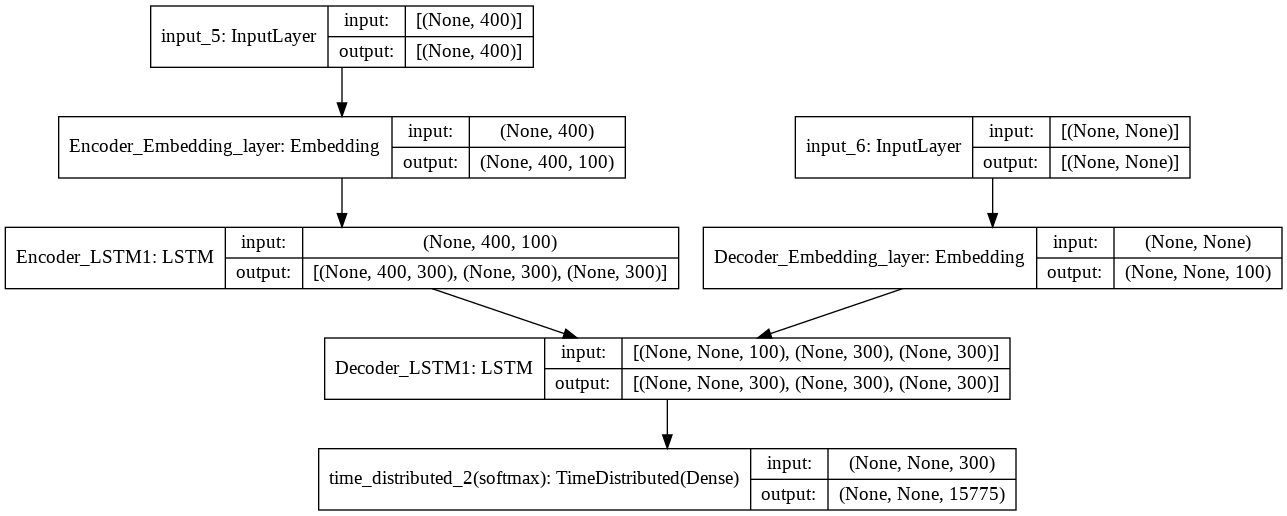

In [124]:
plot_model(model,show_shapes=True)

In [93]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [94]:
history = model.fit([padded_X_train,padded_Y_train[:,:-1]],padded_Y_train[:,1:],
          epochs=1,
          validation_data=([padded_X_val,padded_Y_val[:,:-1]],padded_Y_val[:,1:]),
          batch_size=64)

49/49 [==============================] - 18s 307ms/step - loss: 8.4744 - accuracy: 0.0796 - val_loss: 6.6669 - val_accuracy: 0.0914


In [95]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [96]:
import matplotlib.pyplot as plt

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [98]:
epochs = range(1,len(acc)+1)

<Figure size 432x288 with 0 Axes>

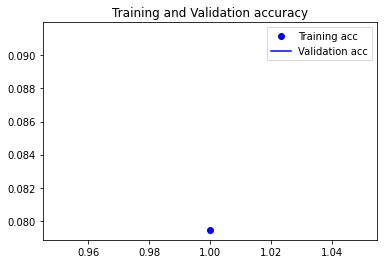

<Figure size 432x288 with 0 Axes>

In [99]:
plt.plot(epochs , acc , 'bo' ,  label = 'Training acc')
plt.plot(epochs , val_acc , 'b' ,  label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()


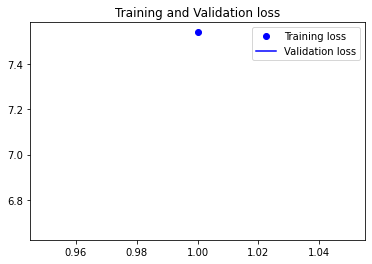

In [100]:
plt.plot(epochs , loss , 'bo' ,  label = 'Training loss')
plt.plot(epochs , val_loss , 'b' ,  label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [101]:
infencoder_model=Model(inputs=[encoder_inputs],outputs=[enclstm1_outputs,enclstm1_h,enclstm1_c])

infdecoder_model_state_input_h=Input(shape=(300,),name='infdec_I1')
infdecoder_model_state_input_c=Input(shape=(300,),name='infdec_I2')

infdeclstm1_output,infdec_h,infdec_c=decoder_lstm1(decoder_emb,initial_state=[infdecoder_model_state_input_h,
                                                                                                infdecoder_model_state_input_c
                                                                                               ])

infdec_output=output_layer(infdeclstm1_output)                         

infdecoder_model=Model(inputs=[decoder_inputs]+[infdecoder_model_state_input_h,infdecoder_model_state_input_c],
                       outputs=[infdec_output]+[infdec_h,infdec_c])

In [102]:
from tensorflow.keras.utils import plot_model

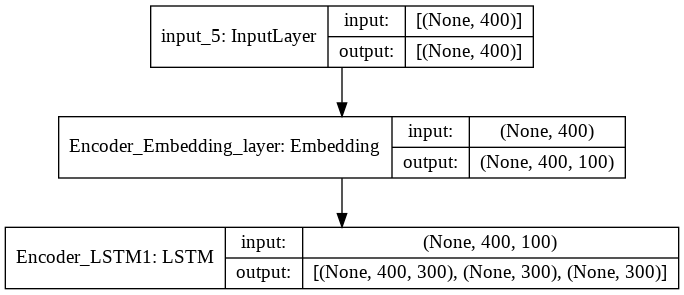

In [103]:
plot_model(infencoder_model,show_shapes=True)

In [104]:
infdecoder_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder_Embedding_layer (Embedd (None, None, 100)    1577500     input_6[0][0]                    
__________________________________________________________________________________________________
infdec_I1 (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
infdec_I2 (InputLayer)          [(None, 300)]        0                                            
____________________________________________________________________________________________

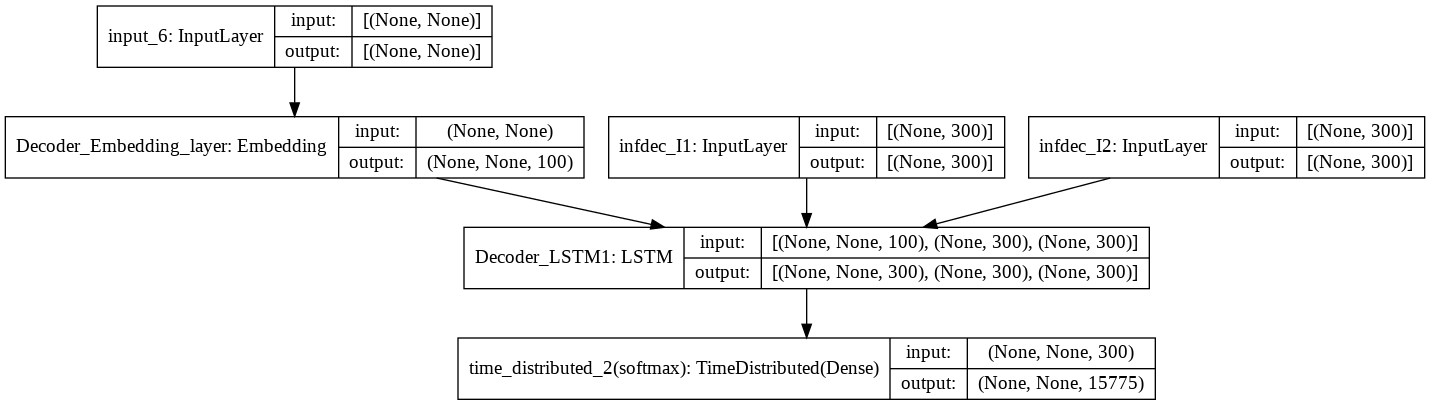

In [105]:
plot_model(infdecoder_model,show_shapes=True)

In [106]:
def decode_sequence(inp_seq):
    
    enc_out,enc_h,enc_c=infencoder_model.predict(inp_seq)
    
    tar_seq=np.zeros((1,1))
    tar_seq[0,0]=sum_wordindex['start']
    
    stop_loop=False
    decoded_string=''
    
    while not stop_loop:
       
        dec_out,dec_h,dec_c=infdecoder_model.predict([tar_seq]+[enc_h,enc_c])
        
        tar_token_index=np.argmax(dec_out[0,-1,:])
        tar_token_word=sum_wordindex[tar_token_index]
        
        if tar_token_word =='end' or len(decoded_string)>=max_art_len:
            
            stop_loop=True
        else:
            decoded_string+=tar_token_word
            
            tar_seq=np.zeros((1,1))
            tar_seq[0,0]=tar_token_index
            
            
            enc_h=dec_h
            enc_c=dec_c
            
    return decoded_string

In [107]:
def seq2art(inp_seq):
    
    art=''
    
    for i in range(len(inp_seq)):
        
        if inp_seq[i]==0:
            break
        art+=reverse_art_index[inp_seq[i]]+' '
        
    return art


def seq2sum(inp_seq):
    
    summary=''
    
    for i in range(len(inp_seq)):
        
        if inp_seq[i]==0:
            break
        word=reverse_sum_index[inp_seq[i]]
        summary+=word+' '
            
    return summary

In [108]:
reverse_art_index=article_tokenizer.index_word
reverse_sum_index=summary_tokenizer.index_word
sum_wordindex=summary_tokenizer.word_index

In [109]:
print('Example Articel : '+'\n',seq2art(padded_X_val[2]))
print('Example Summary : '+'\n',seq2sum(padded_Y_val[2]))


Example Articel : 
 lib dems stress budget trust gappublic trust in the handling of the economy can only be restored if gordon brown opens up his books for unbiased say the lib experts say there is a black hole in the public a claim denied by the lib dem spokesman vince cable said the public did not know who to believe and the national audit office should responding to the mr cable also attacked labour unfair and his mr brown insisted he was on course to meet his golden rule of borrowing only to rather than for over the course of the economic mr cable said people did not know whether to believe the chancellor or the consensus among experts which said the rule would be there is an issue of credibility and he we cannot have a continuation of a situation where the chancellor sets his own tests and then marks what we need is the equivalent of a thorough ofsted inspection of the government he asked what the government had to cable also accused the chancellor of ducking tough he there are se

In [110]:
import numpy as np

In [126]:
padded_X_val[2]

array([  473,   909,  4207,   499,   861, 24088,   861,     7,     2,
        2428,     4,     2,   246,    55,    75,    15,  7361,    59,
         694,   194,  2056,    47,    29,  2133,     9, 13872,   145,
           2,   473,  1213,   145,    50,     8,     6,   682,  3595,
           7,     2,   138,     6,   619,   580,    25,     2,   473,
        1104,   219,  7246,  1576,    19,     2,   138,   112,    24,
         235,    44,     3,   301,     5,     2,   259,  2490,   314,
          85,  3410,     3,     2,    33,  1576,    43,  1932,   103,
        2766,     5,    29,    33,   194,   798,    14,    13,    11,
        1040,     3,   524,    29,   868,  1116,     4,  2253,    75,
           3,   425,    53,     9,    61,     2,  1040,     4,     2,
         190,    33,  1576,    19,    46,   112,    24,   235,   253,
           3,   301,     2,   363,    52,     2,  3921,   352,  1213,
          38,    19,     2,  1116,    34,    15,    50,     8,    32,
         455,     4,

In [119]:
enc_out,enc_h,enc_c=infencoder_model.predict(padded_X_val[2])
tar_seq=np.zeros((1,1))
tar_seq[0,0]=sum_wordindex['start']
    
stop_loop=False
decoded_string=''
    

In [137]:
sum_wordindex['start']

17

In [127]:
tar_seq

array([[17.]])

In [131]:
enc_out.shape

(400, 1, 300)

In [132]:
enc_h.shape

(400, 300)

In [133]:
enc_c.shape

(400, 300)

In [140]:
dec_out,dec_h,dec_c=infdecoder_model.predict([tar_seq]+[enc_out,enc_h,enc_c])

ValueError: ignored

In [ ]:

        
        tar_token_index=np.argmax(dec_out[0,-1,:])
        tar_token_word=sum_wordindex[tar_token_index]
        
        if tar_token_word =='end' or len(decoded_string)>=max_art_len:
            
            stop_loop=True
        else:
            decoded_string+=tar_token_word
            
            tar_seq=np.zeros((1,1))
            tar_seq[0,0]=tar_token_index
            
            
            enc_h=dec_h
            enc_c=dec_c

In [125]:

print('Predicted Summary : '+'\n',decode_sequence([padded_X_val[2]]))

ValueError: ignored